<a href="https://colab.research.google.com/github/Tefong35/TefongEugene/blob/main/RNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/Projet_DataScientest/ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(5)

Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O

In [ ]:
data = data.copy()

# check unique words and tags
print(f"Corpus Contain {data['Word'].nunique()} unique words")
print(f"Corpus Contain {data['Tag'].nunique()} unique tags")

# visualize tags counts
import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

Corpus Contain 35178 unique words
Corpus Contain 17 unique tags


In [ ]:
data.shape

(1048575, 4)

In [ ]:
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     #s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

sentence_all = sentence_integrate(data)


In [ ]:
sentence_all[10]

[('In', 'O'),
 ('Beirut', 'B-geo'),
 (',', 'O'),
 ('a', 'O'),
 ('string', 'O'),
 ('of', 'O'),
 ('officials', 'O'),
 ('voiced', 'O'),
 ('their', 'O'),
 ('anger', 'O'),
 (',', 'O'),
 ('while', 'O'),
 ('at', 'O'),
 ('the', 'O'),
 ('United', 'B-org'),
 ('Nations', 'I-org'),
 ('summit', 'O'),
 ('in', 'O'),
 ('New', 'B-geo'),
 ('York', 'I-geo'),
 (',', 'O'),
 ('Prime', 'B-per'),
 ('Minister', 'O'),
 ('Fouad', 'B-per'),
 ('Siniora', 'I-per'),
 ('said', 'O'),
 ('the', 'O'),
 ('Lebanese', 'B-gpe'),
 ('people', 'O'),
 ('are', 'O'),
 ('resolute', 'O'),
 ('in', 'O'),
 ('preventing', 'O'),
 ('such', 'O'),
 ('attempts', 'O'),
 ('from', 'O'),
 ('destroying', 'O'),
 ('their', 'O'),
 ('spirit', 'O'),
 ('.', 'O')]

In [ ]:
max_len = max(len(sentence) for sentence in sentence_all)
print("max sentence lentgh: ", max_len)

max sentence lentgh:  104


In [ ]:
import tensorflow as tf
sentences = []
for sample in sentence_all:
   sentence = [i[0] for i in sample]
   sentences.append(sentence)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=data['Word'].nunique(), lower=True)
tokenizer.fit_on_texts(sentences)

In [ ]:
labels = []
for sample in sentence_all:
   sentence = [i[1] for i in sample]
   labels.append(sentence)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=data['Tag'].nunique(), lower=True)
tokenizer.fit_on_texts(labels)

In [ ]:
words = data['Word'].unique().tolist()
words.append('ENDPAD')
tags = data['Tag'].unique().tolist()
tags_count = len(tags)
words_count = len(words)

In [ ]:
#2- Create index mapping for words and tags

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
word2idx

{('Thousands', 'O'): 1,
 ('of', 'O'): 18,
 ('demonstrators', 'O'): 3,
 ('have', 'O'): 4,
 ('marched', 'O'): 5,
 ('through', 'O'): 6,
 ('London', 'B-geo'): 7,
 ('to', 'O'): 8,
 ('protest', 'O'): 9,
 ('the', 'O'): 16,
 ('war', 'O'): 11,
 ('in', 'O'): 12,
 ('Iraq', 'B-geo'): 13,
 ('and', 'O'): 14,
 ('demand', 'O'): 15,
 ('withdrawal', 'O'): 17,
 ('British', 'B-gpe'): 19,
 ('troops', 'O'): 20,
 ('from', 'O'): 21,
 ('that', 'O'): 22,
 ('country', 'O'): 23,
 ('.', 'O'): 24}

In [ ]:
from keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
X = [[word2idx[w] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=words_count - 1)

y = [[tag2idx[w] for w in s] for s in labels]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
#y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018, test_size=0.2)

In [ ]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018, test_size=0.2)

In [ ]:
#build model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras
#tags_count = len(tags)
#words_count = len(words)
model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=words_count, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add( Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 104)          3658616   
                                                                 
 spatial_dropout1d (Spatial  (None, 104, 104)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 104, 200)          164000    
 al)                                                             
                                                                 
Total params: 3822616 (14.58 MB)
Trainable params: 3822616 (14.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


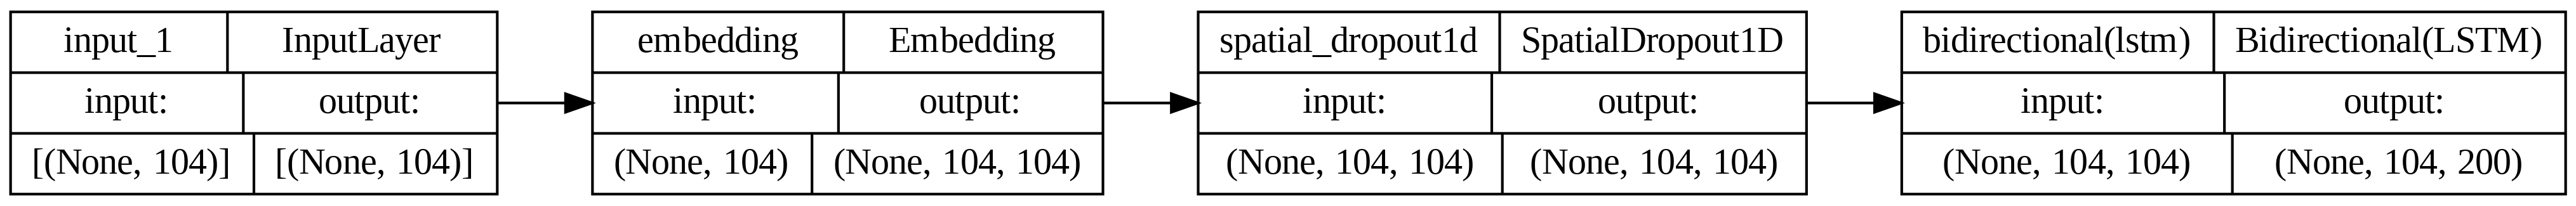

In [ ]:
#show model plot
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [ ]:
#compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping
#import numpy as np
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [early_stopping]

In [ ]:
# train_inputs, temp_inputs, train_tags, temp_tags
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=64,
    epochs=10,
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/10
600/600 [==============================] - 455s 747ms/step - loss: 0.1919 - accuracy: 0.9672 - val_loss: 0.0794 - val_accuracy: 0.9796
Epoch 2/10
600/600 [==============================] - 438s 730ms/step - loss: 0.0675 - accuracy: 0.9826 - val_loss: 0.0642 - val_accuracy: 0.9844
Epoch 3/10
600/600 [==============================] - 430s 716ms/step - loss: 0.0469 - accuracy: 0.9896 - val_loss: 0.0676 - val_accuracy: 0.9879
Epoch 4/10
600/600 [==============================] - 422s 704ms/step - loss: 0.0443 - accuracy: 0.9907 - val_loss: 0.0592 - val_accuracy: 0.9890
Epoch 5/10
600/600 [==============================] - 430s 716ms/step - loss: 0.0486 - accuracy: 0.9901 - val_loss: 0.0573 - val_accuracy: 0.9894
Epoch 6/10
600/600 [==============================] - 421s 702ms/step - loss: 0.0380 - accuracy: 0.9917 - val_loss: 0.0535 - val_accuracy: 0.9896
Epoch 7/10
600/600 [==============================] - 423s 706ms/step - loss: 0.0345 - accuracy: 0.9919 - val_loss: 0.0535 -

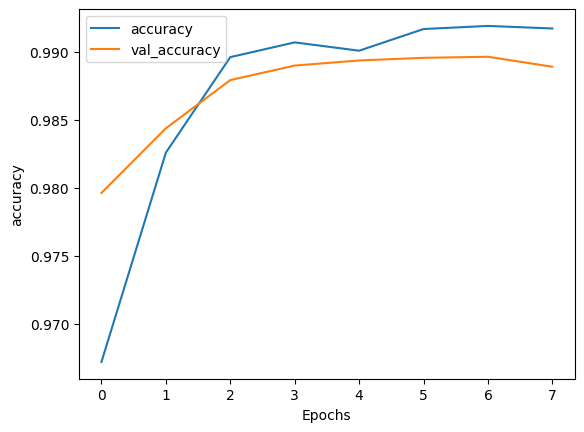

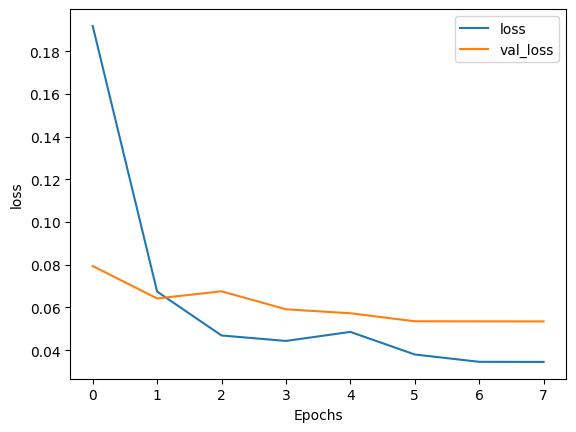

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [ ]:
# métrique 'accuracy'.
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))


Evaluate on test data
75/75 [==============================] - 16s 217ms/step - loss: 0.0535 - accuracy: 0.9889
test loss: 0.0534607470035553 
test accuracy: 0.9889200329780579 


In [ ]:
y_prob = model.predict(X_test[:100])
y_pred = y_prob.argmax(axis=2)

4/4 [==============================] - 1s 63ms/step


In [ ]:
import numpy as np
print('{')
for word, _ in zip(word2idx, range(10)):
    print('  {:4s}: {:3d},'.format(repr(word), word2idx[word]))
print('  ...\n}')

{


TypeError: ignored

In [ ]:
#Exécuter la cellule suivante pour afficher le résulat du modèle sur les 100 premières phrase de X_test
#word2idx = {w: i + 1 for i, w in enumerate(words)}
#char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(words)
def target2text(X_int, y_pred):
    X = []
    for i in range(len(y_pred)):
        text=''
        for j in np.flip(np.arange(len(y_pred[0]))):
            if y_pred[i, j]==1 :
                text = ' ' + text
            text = idx2char[X_int[i, j]] + text
        X.append(text)
    return X

print('Prediction :')
target2text(X_test[:len(y_pred)], y_pred)


Prediction :


['HousestheywarinvasionkidnappedbodiesIraqwarsoftwaredemonstratorsPutumayoMalikBaduelswapraidrallyAIDsboatIraqresponded34wellFamiliesBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermel',
 'resumption wantsIsfahanplantaredividedMilitantpurposesDonaldformalityFamiliesBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBermelBerme

In [ ]:
df = data.copy()
df = df.drop(["POS"], axis=1)
df = df.groupby("Sentence #").agg(list)
df = df.reset_index(drop=True)
df.head()

Word  \
0  [Thousands, of, demonstrators, have, marched, ...   
1  [Iranian, officials, say, they, expect, to, ge...   
2  [Helicopter, gunships, Saturday, pounded, mili...   
3  [They, left, after, a, tense, hour-long, stand...   
4  [U.N., relief, coordinator, Jan, Egeland, said...   

                                                 Tag  
0  [O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...  
1  [B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...  
2  [O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...  
3                  [O, O, O, O, O, O, O, O, O, O, O]  
4  [B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...

In [ ]:
words = data['Word'].unique().tolist()
words.append('ENDPAD')
tags = data['Tag'].unique().tolist()
tags_count = len(tags)
words_count = len(words)

In [ ]:
from tqdm import tqdm
text = ''
for Word in tqdm(data.Word):
    text += ' ' + Word

100%|██████████| 1048575/1048575 [00:00<00:00, 1653088.64it/s]


In [ ]:
import numpy as np
vocab = sorted(list(set(text)))
vocab[0]=''
print('{} uniques characters'.format(len(vocab)))
print(vocab)
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)


99 uniques characters
['', '!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


In [ ]:
#from nltk.tokenize import sent_tokenize
#import seaborn as sns
#import nltk
#nltk.download()
#sentences = np.array(sent_tokenize(text))
#print(len(sentences))
#sns.distplot(list(map(len, sentences)));

# sentences = []
# for sample in sentence_all:
#   sentence = [i[0] for i in sample]
#   sentences.append(sentence)

# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=df['Token'].nunique(), lower=True)
# tokenizer.fit_on_texts(sentences)
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx


{'I-tim': 0,
 'B-tim': 1,
 'I-per': 2,
 'B-nat': 3,
 'I-eve': 4,
 'I-geo': 5,
 'I-gpe': 6,
 'I-org': 7,
 'B-per': 8,
 'B-gpe': 9,
 'I-art': 10,
 'O': 11,
 'B-art': 12,
 'B-eve': 13,
 'I-nat': 14,
 'B-geo': 15,
 'B-org': 16,
 'PAD': 17}

In [ ]:
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     #s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

sentences = sentence_integrate(data)


In [ ]:
#data = data.drop(["POS"], axis=1)
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'I-tim': 0,
 'B-tim': 1,
 'I-per': 2,
 'B-nat': 3,
 'I-eve': 4,
 'I-geo': 5,
 'I-gpe': 6,
 'I-org': 7,
 'B-per': 8,
 'B-gpe': 9,
 'I-art': 10,
 'O': 11,
 'B-art': 12,
 'B-eve': 13,
 'I-nat': 14,
 'B-geo': 15,
 'B-org': 16,
 'PAD': 17}

In [ ]:
max_len = max(len(sentence) for sentence in sentences)
print("max sentence lentgh: ", max_len)

max sentence lentgh:  104


In [ ]:
#import transformers
!pip install transformers
from transformers import BertTokenizer, BertConfig
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
from keras.utils import pad_sequences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", value=0.0,
                          truncating="post", padding="post")
input_ids.shape


(47959, 104)

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=max_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
tags.shape

(47959, 104)

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

len(attention_masks)

47959

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, temp_inputs, train_tags, temp_tags = train_test_split(input_ids, tags,
                                                                    random_state=2018, test_size=0.2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47959 entries, 0 to 47958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    47959 non-null  object
 1   Tag     47959 non-null  object
dtypes: object(2)
memory usage: 749.5+ KB


In [ ]:
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [ ]:
print(sentences[1:3])

[[('Iranian', 'B-gpe'), ('officials', 'O'), ('say', 'O'), ('they', 'O'), ('expect', 'O'), ('to', 'O'), ('get', 'O'), ('access', 'O'), ('to', 'O'), ('sealed', 'O'), ('sensitive', 'O'), ('parts', 'O'), ('of', 'O'), ('the', 'O'), ('plant', 'O'), ('Wednesday', 'B-tim'), (',', 'O'), ('after', 'O'), ('an', 'O'), ('IAEA', 'B-org'), ('surveillance', 'O'), ('system', 'O'), ('begins', 'O'), ('functioning', 'O'), ('.', 'O')], [('Helicopter', 'O'), ('gunships', 'O'), ('Saturday', 'B-tim'), ('pounded', 'O'), ('militant', 'O'), ('hideouts', 'O'), ('in', 'O'), ('the', 'O'), ('Orakzai', 'B-geo'), ('tribal', 'O'), ('region', 'O'), (',', 'O'), ('where', 'O'), ('many', 'O'), ('Taliban', 'B-org'), ('militants', 'O'), ('are', 'O'), ('believed', 'O'), ('to', 'O'), ('have', 'O'), ('fled', 'O'), ('to', 'O'), ('avoid', 'O'), ('an', 'O'), ('earlier', 'O'), ('military', 'O'), ('offensive', 'O'), ('in', 'O'), ('nearby', 'O'), ('South', 'B-geo'), ('Waziristan', 'I-geo'), ('.', 'O')]]


In [ ]:
words = data['Word'].unique().tolist()
words.append('ENDPAD')
tags = data['Tag'].unique().tolist()
tags_count = len(tags)
words_count = len(words)

In [ ]:
# check unique words and tags
print(f"Corpus Contain {data['Word'].nunique()} unique words")
print(f"Corpus Contain {data['Tag'].nunique()} unique tags")


Corpus Contain 35178 unique words
Corpus Contain 17 unique tags


In [ ]:
# visualize tags counts
import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()


In [ ]:
words = data['Word'].unique().tolist()
words.append('ENDPAD')
tags = data['Tag'].unique().tolist()
tags_count = len(tags)
words_count = len(words)

In [ ]:
#2- Create index mapping for words and tags

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
maxlen = max([len(s) for s in sentences])
maxlen

104

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=words_count - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
#y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#build model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras
tags_count = len(tags)
words_count = len(words)
model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=words_count, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add( Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

#model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 104)          3658616   
                                                                 
 spatial_dropout1d (Spatial  (None, 104, 104)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 104, 200)          164000    
 al)                                                             
                                                                 
Total params: 3822616 (14.58 MB)
Trainable params: 3822616 (14.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


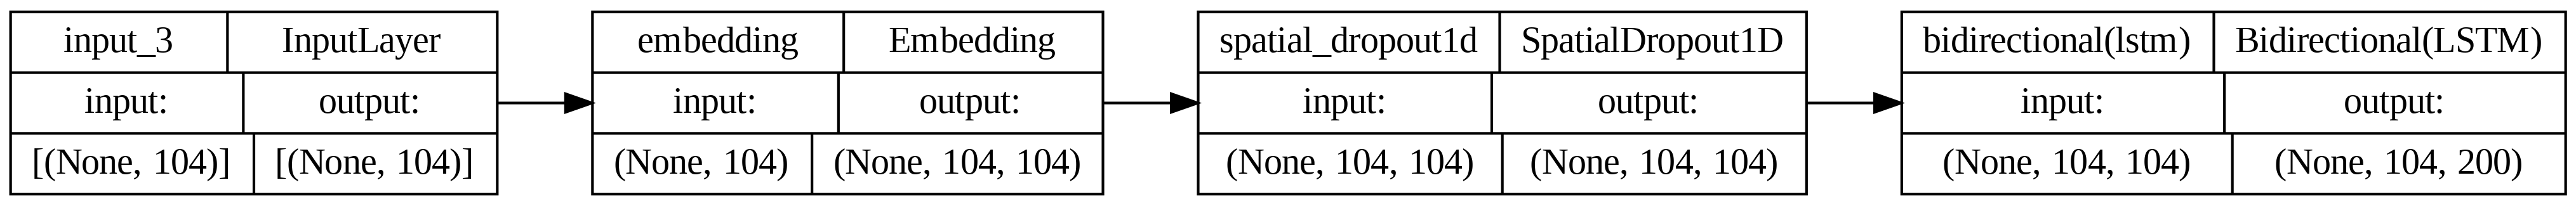

In [ ]:
#show model plot
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [ ]:
#compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping
#from livelossplot.tf_keras import PlotLossesCallback
######
import numpy as np
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [early_stopping]

In [ ]:
# train_inputs, temp_inputs, train_tags, temp_tags
history = model.fit(
    x=train_inputs,
    y=train_tags,
    validation_data=(temp_inputs,temp_tags),
    batch_size=64,
    epochs=10,
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/10
600/600 [==============================] - 422s 695ms/step - loss: 0.2951 - accuracy: 0.9543 - val_loss: 0.1126 - val_accuracy: 0.9733
Epoch 2/10
600/600 [==============================] - 424s 707ms/step - loss: 0.1068 - accuracy: 0.9751 - val_loss: 0.1050 - val_accuracy: 0.9770
Epoch 3/10
501/600 [========================>.....] - ETA: 1:08 - loss: 0.0864 - accuracy: 0.9791

KeyboardInterrupt: ignored

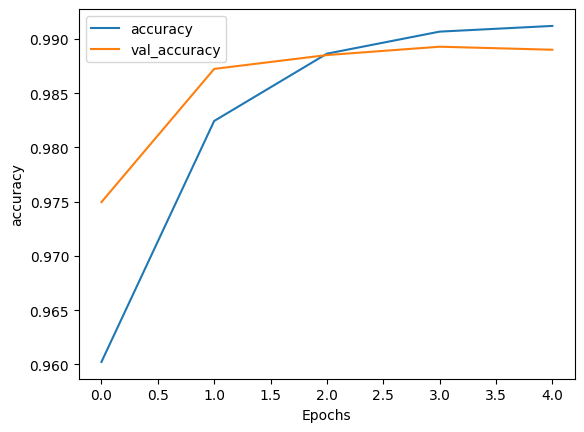

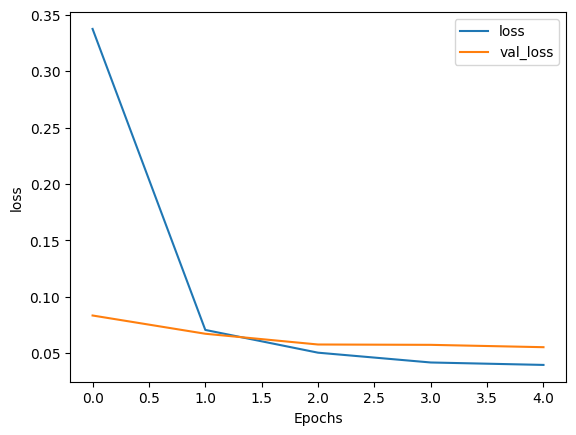

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [ ]:
model.evaluate(X_test, np.array(y_test))

300/300 [==============================] - 31s 104ms/step - loss: 0.0554 - accuracy: 0.9890


[0.0553559847176075, 0.9890022277832031]

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
75/75 [==============================] - 20s 255ms/step - loss: 0.0554 - accuracy: 0.9890
test loss: 0.0553559735417366 
test accuracy: 0.9890022277832031 


In [ ]:
i = np.random.randint(0, X_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_test[i], p[0]):
    print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))

This is sentence: 5743
1/1 [==============================] - 1s 504ms/step
Word           True 	 Pred

------------------------------
comes          O	O
States         B-geo	B-geo
But            I-geo	I-geo
Raad           O	O
and            B-geo	B-geo
lack           O	O
rising         O	O
trade          O	O
extremist      O	O
Institute      O	O
demonstrators  O	O
graves         O	O
Zarqawi        O	O
covertly       O	O
Families       O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPA

In [ ]:
y_train

AttributeError: ignored

In [ ]:
import re, unicodedata
df = pd.DataFrame(df)
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
    w = re.sub(r'\b\w{0,1}\b', '', w)
    w = re.sub(r'\ +', " ", w)
    return w

df.Word = df.Word.apply(lambda x :preprocess_sentence(x))
df.head()


AttributeError: ignored

In [ ]:
words = data['Word'].unique().tolist()
#words.append('ENDPAD')
tags = data['Tag'].unique().tolist()
tags_count = len(tags)
words_count = len(words)



In [ ]:
# check unique words and tags
print(f"Corpus Contain {data['Word'].nunique()} unique words")
print(f"Corpus Contain {data['Tag'].nunique()} unique tags")

# visualize tags counts
import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

Corpus Contain 35178 unique words
Corpus Contain 17 unique tags


In [ ]:
#Processing corpus
#1- group sentences with their corresponding tags
data = data.drop(["POS"], axis=1)
import tqdm

def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     #s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

sentences = sentence_integrate(data)

sentences[10]

[('In', 'O'),
 ('Beirut', 'B-geo'),
 (',', 'O'),
 ('a', 'O'),
 ('string', 'O'),
 ('of', 'O'),
 ('officials', 'O'),
 ('voiced', 'O'),
 ('their', 'O'),
 ('anger', 'O'),
 (',', 'O'),
 ('while', 'O'),
 ('at', 'O'),
 ('the', 'O'),
 ('United', 'B-org'),
 ('Nations', 'I-org'),
 ('summit', 'O'),
 ('in', 'O'),
 ('New', 'B-geo'),
 ('York', 'I-geo'),
 (',', 'O'),
 ('Prime', 'B-per'),
 ('Minister', 'O'),
 ('Fouad', 'B-per'),
 ('Siniora', 'I-per'),
 ('said', 'O'),
 ('the', 'O'),
 ('Lebanese', 'B-gpe'),
 ('people', 'O'),
 ('are', 'O'),
 ('resolute', 'O'),
 ('in', 'O'),
 ('preventing', 'O'),
 ('such', 'O'),
 ('attempts', 'O'),
 ('from', 'O'),
 ('destroying', 'O'),
 ('their', 'O'),
 ('spirit', 'O'),
 ('.', 'O')]

In [ ]:
df.Tag.value_counts

<bound method IndexOpsMixin.value_counts of 0        [O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...
1        [B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...
2        [O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...
3                        [O, O, O, O, O, O, O, O, O, O, O]
4        [B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...
                               ...                        
47954    [O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...
47955    [O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...
47956    [O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...
47957    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
47958    [O, B-org, I-org, O, O, O, O, O, O, O, O, O, O...
Name: Tag, Length: 47959, dtype: object>

In [ ]:

color_mapping = {'O': "CEND", 'B-geo': "CYELLOWBG", 'B-gpe': "CREDBG", 'B-per': "CBLUEBG", 'B-org':"CVIOLETBG",
                 'B-tim': "CBEIGEBG"
                 }
def display_formatted_text(words, tags):
    formatted_text = " ".join([color_mapping[tag] + word for word, tag in zip(words, tags)]) + "CEND"
    print(formatted_text)

text = df.loc[0, "Word"]
tags = df.loc[0, "Tag"]
display_formatted_text(text, tags)

text = df.loc[42, "Word"]
tags = df.loc[42, "Tag"]
display_formatted_text(text, tags)

CENDThousands CENDof CENDdemonstrators CENDhave CENDmarched CENDthrough CYELLOWBGLondon CENDto CENDprotest CENDthe CENDwar CENDin CYELLOWBGIraq CENDand CENDdemand CENDthe CENDwithdrawal CENDof CREDBGBritish CENDtroops CENDfrom CENDthat CENDcountry CEND.CEND


KeyError: ignored